<a href="https://colab.research.google.com/github/abelardoaguilar/Bioinformatic_Tools_Spring_2025/blob/main/1_assignment_bioinformatics_pipeline/bin/BioTools_Assignment_1_Solution_AAC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup Initial Block

Run this cell first to ensure that all dependencies are installed:

In [1]:
# Setup Initial Block: Install dependencies
# Uncomment and run the following commands if you haven't installed these packages.

!pip install biopython seaborn matplotlib pandas requests lxml scikit-bio


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 31.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 15.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 67.1 MB/s eta 0:00:00
  Created wheel for scikit-bio: filename=scikit_bio-0.6.3-cp311-cp311-linux_x86_64.whl size=7294568 sha256=f45234584467351a7f73eac15b8f1e872bf29028866c919a6817c90c09ced7dc
  Stored in directory: /root/.cache/pip/wheels/c9/11/a2/86492071506a487bcba7015b710a9e89d66ca69845512fb86c
  Created wheel for biom-format: filename=biom_format-2.1.16-cp311-cp311-linux_x86_64.whl size=12182993 sha256=7379d3bf10573ff1e3902cc4a28b2d4131e61551bc4a0d4d4e615bc1eba535ad
  Stored in directory: /root/.cache/pi

In [3]:
# INPUT/OUTPUT

# Import Colab file upload module.
from google.colab import files

# Upload your FASTA file from your local computer.
uploaded = files.upload()

# Get the filename of the uploaded FASTA file.
fasta_file_path = list(uploaded.keys())[0]
print(f"Uploaded file: {fasta_file_path}")

# Define the output directory.
OUTPUT_DIR = "output"
import os
os.makedirs(OUTPUT_DIR, exist_ok=True)



Saving sequences.fna to sequences.fna
Uploaded file: sequences.fna


# Chunk 1: Sequence Translation, Feature Calculation, and Visualization

This chunk reads nucleotide sequences from a FASTA file, translates them to protein sequences, calculates basic features (sequence length and GC content), and creates visualizations.

Sequence features saved to output/sequence_features.csv


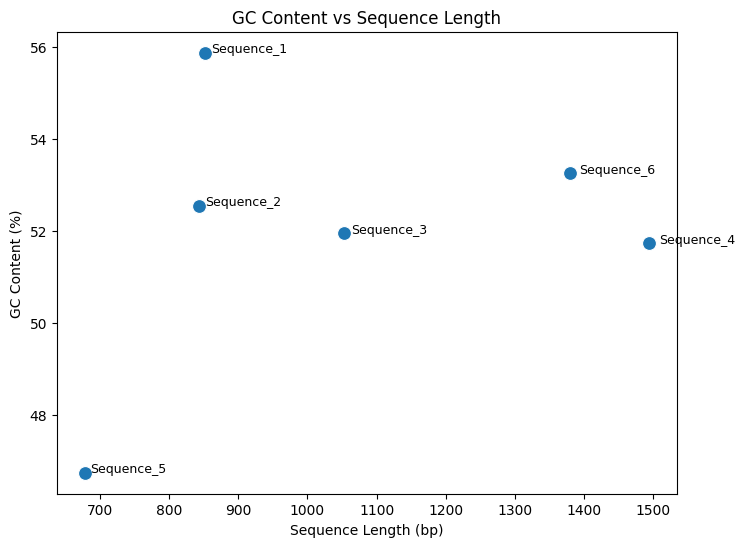

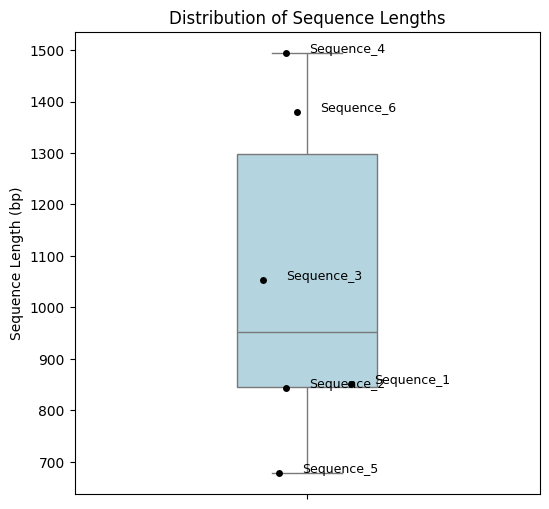

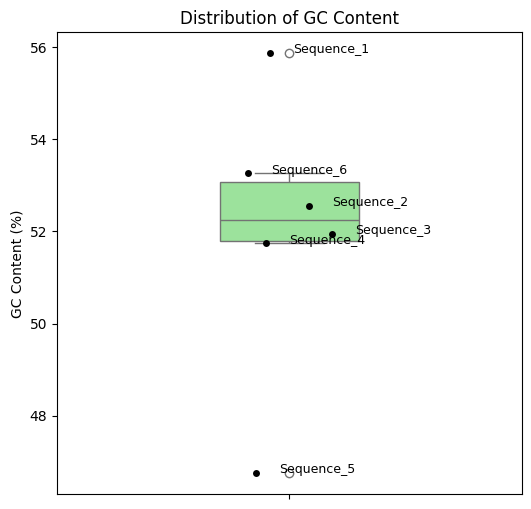

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from Bio import SeqIO
from Bio.SeqRecord import SeqRecord

def read_and_translate_sequences(input_filepath: str, output_directory: str):
    """
    Reads nucleotide sequences from a FASTA file, translates them (stopping at the first stop codon),
    and writes the translated sequences to a new FASTA file.

    Parameters:
        input_filepath (str): Path to the nucleotide FASTA file.
        output_directory (str): Directory to save the translated sequences.

    Returns:
        list: Original nucleotide sequence records.
    """
    nucleotide_records = []
    translated_records = []

    with open(input_filepath) as fasta_file:
        for record in SeqIO.parse(fasta_file, "fasta"):
            nucleotide_records.append(record)
            translated_seq = record.seq.translate(to_stop=True)
            translated_records.append(SeqRecord(translated_seq, id=record.id, description=""))

    translated_filepath = os.path.join(output_directory, "translated_sequences.faa")
    SeqIO.write(translated_records, translated_filepath, "fasta")
    return nucleotide_records

def calculate_sequence_features(records):
    """
    Computes basic features for each sequence: length and GC content (percentage).

    Parameters:
        records (list): List of nucleotide sequence records.

    Returns:
        DataFrame: Pandas DataFrame with columns 'sequence_id', 'sequence_length', and 'gc_content'.
    """
    features = []
    for record in records:
        seq_str = str(record.seq).upper()
        seq_length = len(seq_str)
        gc_content = (seq_str.count("G") + seq_str.count("C")) / seq_length * 100 if seq_length > 0 else 0
        features.append({
            "sequence_id": record.id,
            "sequence_length": seq_length,
            "gc_content": gc_content
        })
    return pd.DataFrame(features)

def create_visualizations(feature_df, output_directory: str):
    """
    Generates visualizations for sequence features:
      - Scatterplot of GC content vs. sequence length (with sequence labels).
      - Boxplots (with overlaid stripplots) for sequence length and GC content.

    Parameters:
        feature_df (DataFrame): DataFrame with sequence features.
        output_directory (str): Directory to save the plots.
    """
    # Scatterplot: GC content vs. Sequence Length.
    plt.figure(figsize=(8, 6))
    ax_scatter = sns.scatterplot(data=feature_df, x="sequence_length", y="gc_content", s=100)
    plt.title("GC Content vs Sequence Length")
    plt.xlabel("Sequence Length (bp)")
    plt.ylabel("GC Content (%)")
    for idx, row in feature_df.iterrows():
        ax_scatter.text(row["sequence_length"] * 1.01, row["gc_content"], row["sequence_id"], fontsize=9)
    scatter_path = os.path.join(output_directory, "gc_vs_length_scatter.png")
    plt.savefig(scatter_path, bbox_inches="tight")

    # Boxplot for Sequence Length.
    plt.figure(figsize=(6, 6))
    ax_length = plt.gca()
    sns.boxplot(y=feature_df["sequence_length"], width=0.3, color="lightblue", ax=ax_length)
    sns.stripplot(y=feature_df["sequence_length"], jitter=True, color="black", ax=ax_length)
    offsets_length = ax_length.collections[-1].get_offsets()
    for i, (x, y) in enumerate(offsets_length):
        ax_length.text(x + 0.05, y, feature_df["sequence_id"].iloc[i], fontsize=9)
    plt.title("Distribution of Sequence Lengths")
    plt.ylabel("Sequence Length (bp)")
    length_path = os.path.join(output_directory, "sequence_length_boxplot.png")
    plt.savefig(length_path, bbox_inches="tight")

    # Boxplot for GC Content.
    plt.figure(figsize=(6, 6))
    ax_gc = plt.gca()
    sns.boxplot(y=feature_df["gc_content"], width=0.3, color="lightgreen", ax=ax_gc)
    sns.stripplot(y=feature_df["gc_content"], jitter=True, color="black", ax=ax_gc)
    offsets_gc = ax_gc.collections[-1].get_offsets()
    for i, (x, y) in enumerate(offsets_gc):
        ax_gc.text(x + 0.05, y, feature_df["sequence_id"].iloc[i], fontsize=9)
    plt.title("Distribution of GC Content")
    plt.ylabel("GC Content (%)")
    gc_box_path = os.path.join(output_directory, "gc_content_boxplot.png")
    plt.savefig(gc_box_path, bbox_inches="tight")

def main_visualization():
    nucleotide_records = read_and_translate_sequences(fasta_file_path, OUTPUT_DIR)
    feature_df = calculate_sequence_features(nucleotide_records)
    feature_csv = os.path.join(OUTPUT_DIR, "sequence_features.csv")
    feature_df.to_csv(feature_csv, index=False)
    print(f"Sequence features saved to {feature_csv}")
    create_visualizations(feature_df, OUTPUT_DIR)

# Execute visualization pipeline.
main_visualization()


Explanation:

*    The read_and_translate_sequences function reads the original nucleotide FASTA file, translates each sequence, and saves the protein sequences.

*    The calculate_sequence_features function computes the length and GC content for each sequence and returns a DataFrame.

*    The create_visualizations function generates a scatterplot and boxplots (with overlaid stripplots) for visualizing the sequence features.

*    The main function ties these steps together.

# Chunk 2: Phylogenetic Analysis with Pairwise Distance Matrix and Neighbor Joining Tree

This chunk computes a pairwise distance matrix using a simple global alignment method, visualizes the distance matrix as a heatmap with a dendrogram, and constructs a Neighbor Joining (NJ) tree using scikit‐bio.

Pairwise Distance Matrix:
            Sequence_1  Sequence_2  Sequence_3  Sequence_4  Sequence_5  \
Sequence_1    0.000000    0.452055    0.759766    0.787597    0.776442   
Sequence_2    0.452055    0.000000    0.779923    0.790373    0.771845   
Sequence_3    0.759766    0.779923    0.000000    0.785408    0.792453   
Sequence_4    0.787597    0.790373    0.785408    0.000000    0.784874   
Sequence_5    0.776442    0.771845    0.792453    0.784874    0.000000   
Sequence_6    0.787928    0.790850    0.772727    0.773077    0.802102   

            Sequence_6  
Sequence_1    0.787928  
Sequence_2    0.790850  
Sequence_3    0.772727  
Sequence_4    0.773077  
Sequence_5    0.802102  
Sequence_6    0.000000  


/usr/local/lib/python3.11/dist-packages/seaborn/matrix.py:530: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,
/usr/local/lib/python3.11/dist-packages/seaborn/matrix.py:530: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,


Heatmap saved as: output/distance_heatmap.png
Neighbor Joining tree saved as: output/neighbor_joining_tree.png


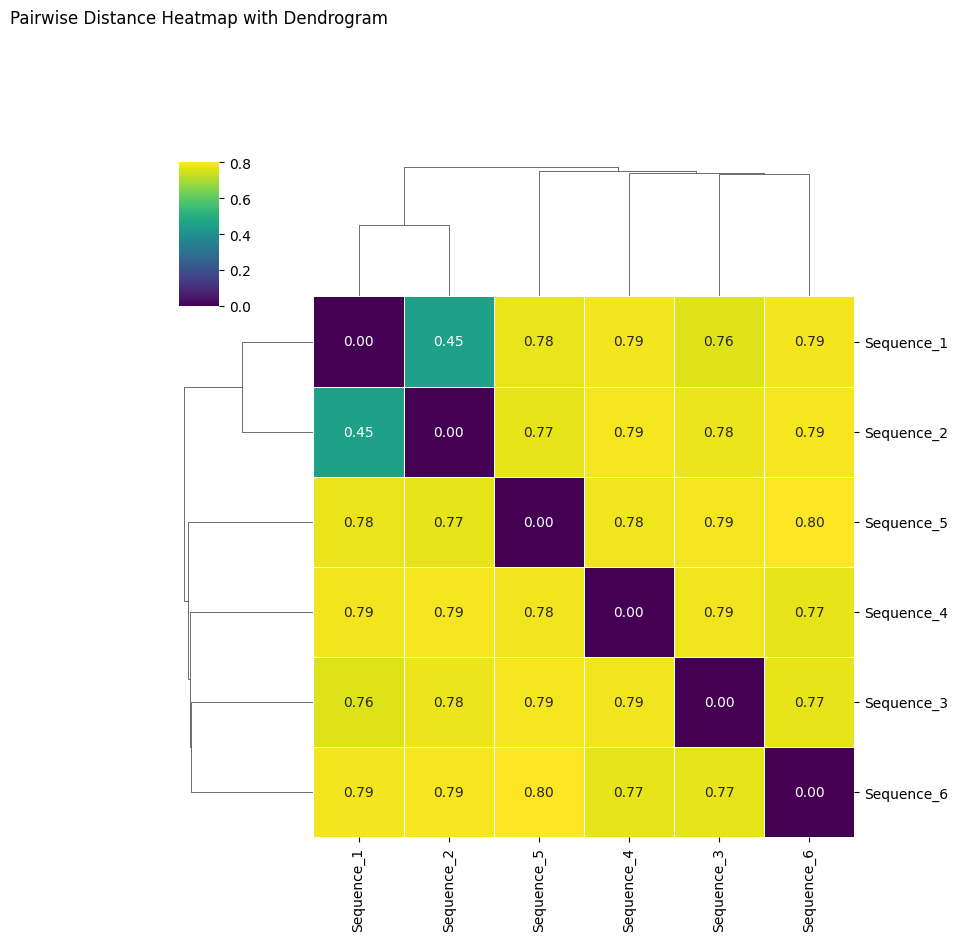

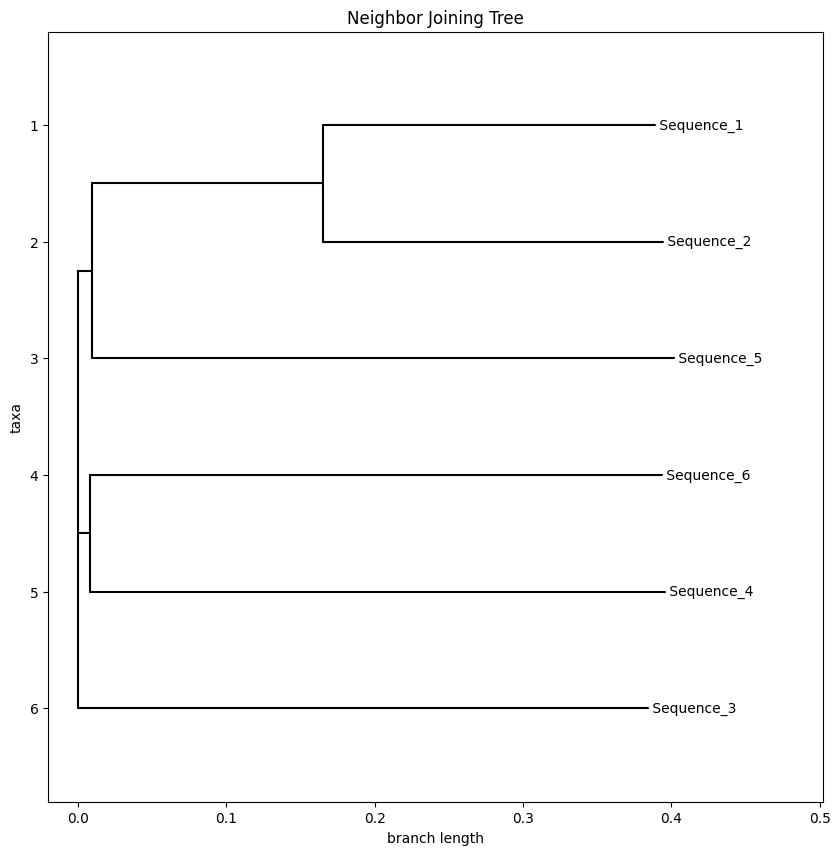

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from io import StringIO

from Bio import SeqIO, pairwise2, Phylo
from skbio import DistanceMatrix as SkbioDistanceMatrix
from skbio.tree import nj

def read_translated_sequences(filepath):
    """
    Reads translated sequences from a FASTA file.

    Parameters:
        filepath (str): Path to the translated FASTA file.

    Returns:
        list: List of SeqRecord objects.
    """
    return list(SeqIO.parse(filepath, "fasta"))

def compute_pairwise_distance_matrix(records):
    """
    Computes a pairwise distance matrix using global alignment.

    Distance = 1 - (alignment score / alignment length).

    Parameters:
        records (list): List of translated sequence records.

    Returns:
        DataFrame: Symmetric DataFrame with pairwise distances.
    """
    ids = [record.id for record in records]
    n = len(records)
    dist_matrix = pd.DataFrame(np.zeros((n, n)), index=ids, columns=ids)

    for i in range(n):
        for j in range(i+1, n):
            seq1 = str(records[i].seq)
            seq2 = str(records[j].seq)
            alignment = pairwise2.align.globalxx(seq1, seq2)[0]
            similarity = alignment.score / len(alignment.seqA)
            distance = 1 - similarity
            dist_matrix.iloc[i, j] = distance
            dist_matrix.iloc[j, i] = distance
    return dist_matrix

def plot_distance_heatmap(distance_matrix, output_filepath):
    """
    Plots a heatmap with dendrogram for the pairwise distance matrix.

    Parameters:
        distance_matrix (DataFrame): DataFrame of pairwise distances.
        output_filepath (str): Path to save the heatmap image.
    """
    cg = sns.clustermap(distance_matrix, annot=True, fmt=".2f", cmap="viridis",
                        linewidths=0.5, figsize=(8,8))
    plt.title("Pairwise Distance Heatmap with Dendrogram", pad=100)
    plt.savefig(output_filepath, bbox_inches="tight")

def build_neighbor_joining_tree_skbio(distance_matrix, output_filepath):
    """
    Constructs a Neighbor Joining tree using scikit-bio and plots it.

    Parameters:
        distance_matrix (DataFrame): Pairwise distance DataFrame.
        output_filepath (str): Path to save the NJ tree plot.
    """
    labels = list(distance_matrix.index)
    skbio_dm = SkbioDistanceMatrix(distance_matrix.values, ids=labels)
    tree = nj(skbio_dm)

    newick_io = StringIO()
    tree.write(file=newick_io)
    newick_str = newick_io.getvalue()

    tree_io = StringIO(newick_str)
    phylo_tree = Phylo.read(tree_io, "newick")

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1, 1, 1)
    Phylo.draw(phylo_tree, do_show=False, axes=ax)
    plt.title("Neighbor Joining Tree")
    plt.savefig(output_filepath, bbox_inches="tight")

# Define file paths based on OUTPUT_DIR.
translated_filepath = os.path.join(OUTPUT_DIR, "translated_sequences.faa")
heatmap_output = os.path.join(OUTPUT_DIR, "distance_heatmap.png")
tree_output = os.path.join(OUTPUT_DIR, "neighbor_joining_tree.png")

# Step 1: Read translated sequences.
translated_records = read_translated_sequences(translated_filepath)
# Step 2: Compute the pairwise distance matrix.
distance_matrix = compute_pairwise_distance_matrix(translated_records)
print("Pairwise Distance Matrix:")
print(distance_matrix)
# Step 3: Plot and save the heatmap.
plot_distance_heatmap(distance_matrix, heatmap_output)
print(f"Heatmap saved as: {heatmap_output}")
# Step 4: Build and save the NJ tree.
build_neighbor_joining_tree_skbio(distance_matrix, tree_output)
print(f"Neighbor Joining tree saved as: {tree_output}")


Explanation:

*    read_translated_sequences loads protein sequences from a FASTA file.

*    compute_pairwise_distance_matrix aligns each pair of sequences using a simple global alignment and calculates the distance.

*    plot_distance_heatmap visualizes the distance matrix along with a dendrogram.

*    build_neighbor_joining_tree_skbio uses scikit‐bio to generate an NJ tree and then plots it using Bio.Phylo.

# Chunk 3: Functional and Organism Prediction Pipeline

This chunk handles functional and organism predictions by running BLAST searches and online HMMER queries for each sequence, parsing the results, and saving the output as CSV files.

In [8]:
import os
import re
import requests
from io import StringIO

import pandas as pd
from Bio import SeqIO, Phylo
from Bio.Blast import NCBIWWW, NCBIXML
from lxml import etree

# Use the interactively provided FASTA file.
INPUT_FASTA = fasta_file_path
OUTPUT_DIR = OUTPUT_DIR

def blast_query(seq_record, program="blastx", db="nr", hitlist_size=5, out_dir=OUTPUT_DIR):
    """
    Executes a BLAST search on a sequence record and extracts function and organism predictions.

    Parameters:
        seq_record: A Bio.SeqRecord object.
        program (str): BLAST program (default "blastx").
        db (str): BLAST database (default "nr").
        hitlist_size (int): Number of hits to consider.
        out_dir (str): Directory to save BLAST results.

    Returns:
        tuple: (Function prediction string, organism prediction string)
    """
    sid = seq_record.id
    print(f"Starting BLAST for {sid}...")
    try:
        result_xml = NCBIWWW.qblast(program, db, seq_record.seq, hitlist_size=hitlist_size).read()
    except Exception as ex:
        print(f"BLAST error for {sid}: {ex}")
        result_xml = ""
    blast_file = os.path.join(out_dir, f"{sid}_blast.xml")
    with open(blast_file, "w") as fh:
        fh.write(result_xml)
    print(f"BLAST results for {sid} saved at {blast_file}.")

    func_hits, org_hits = [], []
    try:
        with open(blast_file) as fh:
            blast_rec = NCBIXML.read(fh)
            if blast_rec.alignments:
                for alignment in blast_rec.alignments[:hitlist_size]:
                    func_hits.append(alignment.hit_def)
                    m = re.search(r'\[(.*?)\]', alignment.hit_def)
                    org_hits.append(m.group(1) if m else "Unknown")
            else:
                print(f"No BLAST hits found for {sid}.")
    except Exception as ex:
        print(f"Error parsing BLAST output for {sid}: {ex}")

    return ("; ".join(func_hits) if func_hits else "No hit",
            "; ".join(org_hits) if org_hits else "Unknown")

def hmmer_query(protein_seq, sid, hmmdb="pfam", out_dir=OUTPUT_DIR):
    """
    Submits a protein sequence to the online HMMER service and retrieves the XML result.

    Parameters:
        protein_seq: Protein sequence (Bio.Seq object).
        sid (str): Sequence identifier.
        hmmdb (str): HMMER database (default "pfam").
        out_dir (str): Directory to save HMMER results.

    Returns:
        str: Raw XML result from HMMER.
    """
    url = "https://www.ebi.ac.uk/Tools/hmmer/search/hmmscan"
    payload = {"hmmdb": hmmdb, "seq": str(protein_seq), "domE": "1e-5"}
    headers = {"Expect": "", "Accept": "text/xml"}
    print(f"Submitting HMMER query for {sid}...")
    response = requests.post(url, data=payload, headers=headers)
    if response.status_code != 200:
        raise Exception(f"HMMER error for {sid}: {response.status_code}")
    xml_result = response.text
    hmmer_file = os.path.join(out_dir, f"{sid}_hmmer.xml")
    with open(hmmer_file, "w") as fh:
        fh.write(xml_result)
    print(f"HMMER results for {sid} stored at {hmmer_file}.")
    return xml_result

def extract_domains(xml_data):
    """
    Parses HMMER XML output and extracts domain predictions.

    Parameters:
        xml_data (str): Raw XML from HMMER.

    Returns:
        str: Semicolon-separated string of domain predictions.
    """
    domains = []
    try:
        parser = etree.XMLParser(recover=True)
        root = etree.fromstring(xml_data.encode("utf-8"), parser=parser)
        results = root.find(".//data[@name='results']")
        if results is not None:
            for hit in results.findall("hits"):
                hit_name = hit.get("name") or "UnknownHit"
                for dom in hit.findall("domains"):
                    dom_name = dom.get("alihmmname") or hit_name
                    e_val = dom.get("ievalue") or dom.get("evalue") or "N/A"
                    domains.append(f"{dom_name} (E={e_val})")
    except Exception as ex:
        print(f"Error parsing HMMER XML: {ex}")
    return "; ".join(domains) if domains else "No domains detected"

def run_prediction_pipeline(fasta_file=INPUT_FASTA, out_dir=OUTPUT_DIR):
    """
    Main pipeline that performs BLAST and online HMMER queries on each sequence,
    and saves domain, organism, and function predictions to CSV files.
    """
    records = list(SeqIO.parse(fasta_file, "fasta"))
    domain_results, org_func_results, overall_org = [], [], []

    for rec in records:
        sid = rec.id
        print(f"\nProcessing sequence {sid}...")
        func_pred, org_pred = blast_query(rec)
        org_func_results.append({
            "Sequence_ID": sid,
            "Predicted_Organism": org_pred,
            "Function_Prediction": func_pred
        })

        protein = rec.seq.translate(to_stop=True)
        try:
            hmmer_xml = hmmer_query(protein, sid)
        except Exception as ex:
            print(f"HMMER query failed for {sid}: {ex}")
            hmmer_xml = ""
        domain_results.append({
            "Sequence_ID": sid,
            "Domain_Predictions": extract_domains(hmmer_xml) if hmmer_xml else "No domains detected"
        })
        overall_org.append({
            "Sequence_ID": sid,
            "Predicted_Organism": org_pred
        })

    pd.DataFrame(domain_results).to_csv(os.path.join(out_dir, "domain_predictions.csv"), index=False)
    print(f"Domain predictions saved to {os.path.join(out_dir, 'domain_predictions.csv')}")

    pd.DataFrame(org_func_results).to_csv(os.path.join(out_dir, "organism_predictions.csv"), index=False)
    print(f"Organism & function predictions saved to {os.path.join(out_dir, 'organism_predictions.csv')}")

    pd.DataFrame(overall_org).to_csv(os.path.join(out_dir, "organism_overall.csv"), index=False)
    print(f"Overall organism predictions saved to {os.path.join(out_dir, 'organism_overall.csv')}")

# Execute the prediction pipeline.
run_prediction_pipeline()



Processing sequence Sequence_1...
Starting BLAST for Sequence_1...
BLAST results for Sequence_1 saved at output/Sequence_1_blast.xml.
Submitting HMMER query for Sequence_1...
HMMER results for Sequence_1 stored at output/Sequence_1_hmmer.xml.

Processing sequence Sequence_2...
Starting BLAST for Sequence_2...
BLAST results for Sequence_2 saved at output/Sequence_2_blast.xml.
Submitting HMMER query for Sequence_2...
HMMER results for Sequence_2 stored at output/Sequence_2_hmmer.xml.

Processing sequence Sequence_3...
Starting BLAST for Sequence_3...
BLAST results for Sequence_3 saved at output/Sequence_3_blast.xml.
Submitting HMMER query for Sequence_3...
HMMER results for Sequence_3 stored at output/Sequence_3_hmmer.xml.

Processing sequence Sequence_4...
Starting BLAST for Sequence_4...
BLAST results for Sequence_4 saved at output/Sequence_4_blast.xml.
Submitting HMMER query for Sequence_4...
HMMER results for Sequence_4 stored at output/Sequence_4_hmmer.xml.

Processing sequence Seq

Explanation:

*    blast_query runs BLAST (using defaults: blastx against nr) on each sequence and extracts hits for function and organism predictions.

*    hmmer_query submits the protein sequence to the online HMMER service (using pfam as default) and saves the XML result.

*    extract_domains parses the HMMER XML to retrieve domain predictions.

*    run_prediction_pipeline iterates over each sequence in the input FASTA file, runs both BLAST and HMMER queries, gathers predictions, and exports the results into CSV files.

# Example of code cell for reorganizing the files
If you run this cell, placeholders for the structural analyses and reports will be generated

In [ ]:
import os
import shutil
from Bio import SeqIO

# Define the main directory name (using "last_name" literally here)
main_dir = "assignment_1_last_name"

# Create the main directory and essential files.
os.makedirs(main_dir, exist_ok=True)
open(os.path.join(main_dir, "readme.md"), 'w').close()
open(os.path.join(main_dir, "report_last_name.docx"), 'w').close()
open(os.path.join(main_dir, "report_last_name.pdf"), 'w').close()

# ---------------------------
# DATA FOLDER
# ---------------------------
data_dir = os.path.join(main_dir, "data")
os.makedirs(data_dir, exist_ok=True)

# Copy the original FASTA file to data/ (the instructor-provided sequences)
shutil.copy(fasta_file_path, os.path.join(data_dir, "sequences.fna"))

# Create folded_proteins folder with one subfolder per sequence.
folded_dir = os.path.join(data_dir, "folded_proteins")
os.makedirs(folded_dir, exist_ok=True)

# Read translated sequences from the output (assumes they exist in output/translated_sequences.faa)
translated_filepath = os.path.join(OUTPUT_DIR, "translated_sequences.faa")
translated_records = list(SeqIO.parse(translated_filepath, "fasta"))
for record in translated_records:
    seq_folder = os.path.join(folded_dir, record.id)
    os.makedirs(seq_folder, exist_ok=True)
    # Create an empty placeholder for the predicted structure.
    open(os.path.join(seq_folder, f"{record.id}.pdb"), 'w').close()

# ---------------------------
# BIN FOLDER
# ---------------------------
bin_dir = os.path.join(main_dir, "bin")
os.makedirs(bin_dir, exist_ok=True)

# ---------------------------
# RESULTS FOLDER
# ---------------------------
results_dir = os.path.join(main_dir, "results")
os.makedirs(results_dir, exist_ok=True)

# (A) Sequence Properties
seq_props_dir = os.path.join(results_dir, "sequence_properties")
os.makedirs(seq_props_dir, exist_ok=True)
# Copy and rename outputs from visualization:
shutil.copy(os.path.join(OUTPUT_DIR, "sequence_features.csv"), os.path.join(seq_props_dir, "properties.csv"))
shutil.copy(os.path.join(OUTPUT_DIR, "sequence_length_boxplot.png"), os.path.join(seq_props_dir, "lengths.png"))
shutil.copy(os.path.join(OUTPUT_DIR, "gc_content_boxplot.png"), os.path.join(seq_props_dir, "gc_content.png"))
shutil.copy(translated_filepath, os.path.join(seq_props_dir, "sequences_translated.faa"))

# (B) Alignments (placeholders since these were not produced)
alignments_dir = os.path.join(results_dir, "alignments")
os.makedirs(alignments_dir, exist_ok=True)
open(os.path.join(alignments_dir, "sequence_alignments_nucleotide.fna"), 'w').close()
open(os.path.join(alignments_dir, "sequence_alignments_proteins.faa"), 'w').close()
open(os.path.join(alignments_dir, "sequence_similarities.csv"), 'w').close()

# (C) Phylogenetic Tree
phylo_dir = os.path.join(results_dir, "phylogenetic_tree")
os.makedirs(phylo_dir, exist_ok=True)
# Copy the neighbor joining tree image as the protein tree visualization.
shutil.copy(os.path.join(OUTPUT_DIR, "neighbor_joining_tree.png"), os.path.join(phylo_dir, "tree_proteins_visualization.png"))
# Create placeholder Newick files (ideally, you would extract the Newick from your NJ tree function).
open(os.path.join(phylo_dir, "tree_proteins.nwk"), 'w').close()
open(os.path.join(phylo_dir, "tree_nucleotides_visualization.png"), 'w').close()
open(os.path.join(phylo_dir, "tree_nucleotides.nwk"), 'w').close()

# (D) Functional Prediction
func_pred_dir = os.path.join(results_dir, "functional_prediction")
os.makedirs(func_pred_dir, exist_ok=True)
shutil.copy(os.path.join(OUTPUT_DIR, "domain_predictions.csv"), os.path.join(func_pred_dir, "domain_predictions.csv"))
# For each sequence, move its HMMER XML to a dedicated folder.
for file in os.listdir(OUTPUT_DIR):
    if file.endswith("_hmmer.xml"):
        seq_id = file.split("_")[0]
        seq_dir = os.path.join(func_pred_dir, seq_id)
        os.makedirs(seq_dir, exist_ok=True)
        shutil.copy(os.path.join(OUTPUT_DIR, file), os.path.join(seq_dir, file))

# (E) Organism Origin
org_origin_dir = os.path.join(results_dir, "organism_origin")
os.makedirs(org_origin_dir, exist_ok=True)
shutil.copy(os.path.join(OUTPUT_DIR, "organism_predictions.csv"), os.path.join(org_origin_dir, "organism_prediction.csv"))
# For each sequence, move its BLAST XML to a dedicated folder.
for file in os.listdir(OUTPUT_DIR):
    if file.endswith("_blast.xml"):
        seq_id = file.split("_")[0]
        seq_dir = os.path.join(org_origin_dir, seq_id)
        os.makedirs(seq_dir, exist_ok=True)
        shutil.copy(os.path.join(OUTPUT_DIR, file), os.path.join(seq_dir, file))

# (F) Predicted Structures Visualizations (placeholder)
pred_struct_dir = os.path.join(results_dir, "predicted_structures_visualizations")
os.makedirs(pred_struct_dir, exist_ok=True)
for record in translated_records:
    placeholder_file = os.path.join(pred_struct_dir, f"{record.id}_structure_visualization.png")
    open(placeholder_file, 'w').close()

# (G) Structural Homology (placeholder)
struct_homology_dir = os.path.join(results_dir, "structural_homology")
os.makedirs(struct_homology_dir, exist_ok=True)
open(os.path.join(struct_homology_dir, "homology_predictions.csv"), 'w').close()

# (H) Pair Homology (placeholder)
pair_homology_dir = os.path.join(results_dir, "pair_homology")
os.makedirs(pair_homology_dir, exist_ok=True)
open(os.path.join(pair_homology_dir, "pair_homology_predictions.csv"), 'w').close()
os.makedirs(os.path.join(pair_homology_dir, "pair_comparisons"), exist_ok=True)

print("Output restructured to match the expected folder structure.")
